## Question C (Ex2, Q3 and Q4 of TD3)

a) Determine the extremal index using the block or run de-clustering, for the two tails of the distributions.

In [1]:
import pandas as pd
import numpy as np

In [2]:
#Import price data
data=pd.read_csv("NatixisStock.csv",header=None, decimal='.', sep=';')
data=data[1:]
data.head

<bound method NDFrame.head of                0      1
1     02/01/2015  5.621
2     05/01/2015  5.424
3     06/01/2015  5.329
4     07/01/2015  5.224
5     08/01/2015  5.453
...          ...    ...
1019  21/12/2018  4.045
1020  24/12/2018   4.01
1021  27/12/2018  3.938
1022  28/12/2018  4.088
1023  31/12/2018  4.119

[1023 rows x 2 columns]>

In [3]:
time=data[0]
prices=data[1].astype(float)

In [4]:
# Compute price returns (here we calculate the logarithmic returns)
returns= np.diff(np.log(prices))

In [5]:
def blocks_declustering(u,b,data):
    num=0
    den=0
    k=int(len(data)/b)
    for i in range(k):
        if max(data[i*b: (i+1)*b-1])>u:
            num+=1
    for i in range (k*b):
        if data[i]>u:
            den+=1
    return num/den

In [6]:
# Set the block size
b = 6

# Compute the extremal index for the upper tail of the distribution
u95 = np.quantile(returns, 0.95)  # 95th percentile of the data
print("95th percentile of the data: ",u95)
extremal_index_upper = blocks_declustering(u95, b, returns)


# Compute the extremal index for the lower tail of the distribution
u5 = np.quantile(returns, 0.05)  # 5th percentile of the data
print("5th percentile of the data: ",u5)
extremal_index_lower = blocks_declustering(u5, b, returns)

print("Extremal index (upper tail):", extremal_index_upper)
print("Extremal index (lower tail):", extremal_index_lower)

95th percentile of the data:  0.03042533972511888
5th percentile of the data:  -0.0322570668810193
Extremal index (upper tail): 0.7254901960784313
Extremal index (lower tail): 0.1756198347107438


We get a larger extremal index for the upper tail of the distribution and a smaller extremal index for the lower tail of the distribution. This suggests that extreme events are more likely to occur in clusters in the upper tail of the distribution, but are more likely to be isolated or scattered in the lower tail of the distribution.

b) Propose an adaptation of the EVT VaR which takes into account the dependence of the returns.

1. Estimate the marginal distributions of the returns using the EVT. Let's use the pickands estimator. 

In [7]:
def k(n):
    return np.log(n) 


def pickands_estimator(data):
    n=len(data)
    res=np.log((data[n-int(k(n))]-data[n-2*int(k(n))])/(data[n-2*int(k(n))]-data[n-4*int(k(n))]))
    return res/np.log(2)

In [8]:
#Sort the returns
returns_sorted=np.sort(returns)
print ( "Pickands Estimator:", pickands_estimator(returns_sorted))

Pickands Estimator: 0.5636820887482262


Selon la theorie des valeurs extremes, on a VaR(p)=...

In [9]:
def var_pickands_EVT (u,p, data) :
    n = len(data)
    e = pickands_estimator (returns_sorted)
    theta = blocks_declustering(u, 6, returns)
    num =(k(n) * theta / (n * (1 - p)))**e-1
    den = 1- 2**(-e)
    return num/den * (data[n - int(theta * k(n))]- data[n -2 * int(theta * k(n))]) + data[n - int(theta * k(n))]

In [10]:
percentile=0.95
u=np.quantile(returns, percentile)
print("EVT VaR:",var_pickands_EVT(u,percentile,returns)*100,"%")

EVT VaR: -3.893481672472428 %


## Question D (Ex2, Q3 and Q4 of TD4)
a) Estimate all the parameters of the model of Almgren and Chriss. Is this model well specified?

b) In the framework of Almgren and Chriss, what is your liquidation strategy (we recall that you can only make transactions once every hour).

## Question E (Q2 and Q3 of TD5)
a) Using dataset provided in TD5, with Haar wavelets and the dataset provided with this tutorial, determine the multiresolution correlation between all the pairs of FX rates, using GBPEUR, SEKEUR, and CADEUR (work with the average between the highest and the lowest price and transform this average price in returns on the smallest time step). Do you observe an Epps effect and how could you explain this?

In [16]:
import pandas as pd

matrix = pd.read_csv("DatasetTD5.csv", header=None, decimal=',', sep=';')

# Average between the highest and the lowest price for FX rates
gbpeur = []
for k in range(2, len(matrix[2])):
    gbpeur.append((float(matrix[1][k].replace(',', '.')) + float(matrix[2][k].replace(',', '.'))) / 2)

sekeur = []
for k in range(2, len(matrix[2])):
    sekeur.append((float(matrix[5][k].replace(',', '.')) + float(matrix[6][k].replace(',', '.'))) / 2)

cadeur = []
for k in range(2, len(matrix[2])):
    cadeur.append((float(matrix[5][k].replace(',', '.')) + float(matrix[6][k].replace(',', '.'))) / 2)


In [12]:
# Haar Function
def haar(t):
    res = 0
    if 1 / 2 > t >= 0:
        res = 1
    elif 1 > t >= 1 / 2:
        res = -1
    return res

In [13]:
# Haar wavelet function
def waveletHaar(j, k, t):
    return 2 ** (j / 2) * haar(t * 2 ** j - k)


In [14]:
# Haar wavelet transform
def haarWaveletTransform(x, j, k):
    n = len(x)
    res = 0
    for u in range(1, n):
        res += waveletHaar(j, k, x[u]) * (x[u] - x[u - 1]) / x[u - 1]
    return res

In [15]:
# Covariance between two series
def cov(j, T, serie1, serie2):
    sum = 0

    s1 = 0
    s2 = 0

    for l in range(1, T):
        s1 += haarWaveletTransform(serie1, j, l)
        s2 += haarWaveletTransform(serie2, j, l)

    for k in range(1, T):
        sum += (haarWaveletTransform(serie1, j, k) - s1 / T) * (haarWaveletTransform(serie2, j, k) - s2 / T)

    return sum / T

In [31]:
# Multiresolution correlation between GBP/EUR and SEK/EUR
j = 5
T = len(gbpeur)
correlation_gbp_sek = cov(j, T, gbpeur, sekeur)

# Multiresolution correlation between GBP/EUR and CAD/EUR
j = 5
T = len(gbpeur)
correlation_gbp_cad = cov(j, T, gbpeur, cadeur)

# Multiresolution correlation between SEK/EUR and CAD/EUR
j = 5
T = len(sekeur)
correlation_sek_cad = cov(j, T, sekeur, cadeur)

print("Multiresolution correlation between GBP/EUR and SEK/EUR: {:.20f}".format(correlation_gbp_sek))
print("Multiresolution correlation between GBP/EUR and CAD/EUR: {:.20f}".format(correlation_gbp_cad))
print("Multiresolution correlation between SEK/EUR and CAD/EUR: {:.20f}".format(correlation_sek_cad))



Multiresolution correlation between GBP/EUR and SEK/EUR: -0.00000000024691494201
Multiresolution correlation between GBP/EUR and CAD/EUR: -0.00000000024691494201
Multiresolution correlation between SEK/EUR and CAD/EUR: 0.00000127654169435275


 Do you observe an Epps effect and how could you explain this?

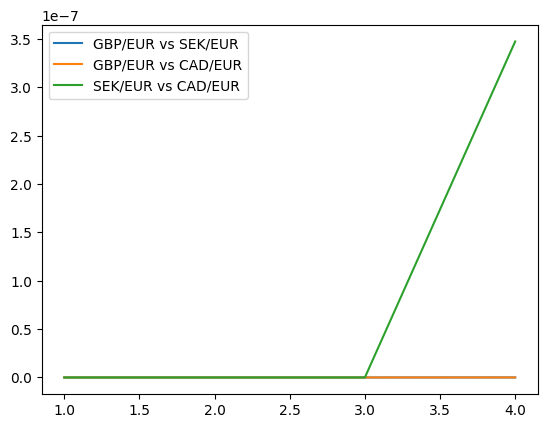

In [34]:
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots()

# Compute the multiresolution correlations for different time scales
correlations_gbp_sek = []
correlations_gbp_cad = []
correlations_sek_cad = []
time_scales = range(1, 5)
for j in time_scales:
    T = len(gbpeur)
    correlations_gbp_sek.append(cov(j, T, gbpeur, sekeur))
    correlations_gbp_cad.append(cov(j, T, gbpeur, cadeur))
    correlations_sek_cad.append(cov(j, T, sekeur, cadeur))

# Plot the multiresolution correlations
ax.plot(time_scales, correlations_gbp_sek, label='GBP/EUR vs SEK/EUR')
ax.plot(time_scales, correlations_gbp_cad, label='GBP/EUR vs CAD/EUR')
ax.plot(time_scales, correlations_sek_cad, label='SEK/EUR vs CAD/EUR')

# Add a legend
ax.legend()

# Show the plot
plt.show()
